In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from functorch import vmap
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts


In [ ]:
class CustomDataset(Dataset):
    '''
    Custom dataset class for data generation.

    Attributes
    ----------
    x_true: numpy array
        True values for x.
    y_true: numpy array
        True values for y.

    Methods
    -------
    __len__()
        get the length of dataset
    __getitem__(size, data_interval)
        get the subset of data for a specific size and x interval
    '''
    def __init__(self, x_true, y_true, power = 1):
        self.x_true = x_true
        self.y_true = y_true
        self.power = power


    def __len__(self):
        return len(self.x_true)

    def __getitem__(self, size, data_interval = [-0.5, 1.5]):
        interval = np.where((x_true >= data_interval[0]) & (x_true <= data_interval[1]))[0]
        rng = np.random.default_rng(seed=42)
        data_inds = rng.integers(low=0, high=interval.size-1, size=size)
        noise_perturbations = rng.normal(loc=0, scale=0.1,size=len(data_inds))
        x_data = x_true[interval][data_inds]
        y_data = y_true[interval][data_inds] + noise_perturbations
        x_power = np.column_stack([x_data**i for i in range(1, power+1)])

        x_data = torch.from_numpy(x_power).float()
        y_data = torch.from_numpy(y_data).float().unsqueeze(1)
        return x_data, y_data


In [ ]:
x_true = np.linspace(-0.5, 1.5, 1000)
y_true = 5* (x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true))
power = 5
dataset = CustomDataset(x_true, y_true, power)
x_train, y_train = dataset.__getitem__(500, data_interval = [-0.2, 1.2])

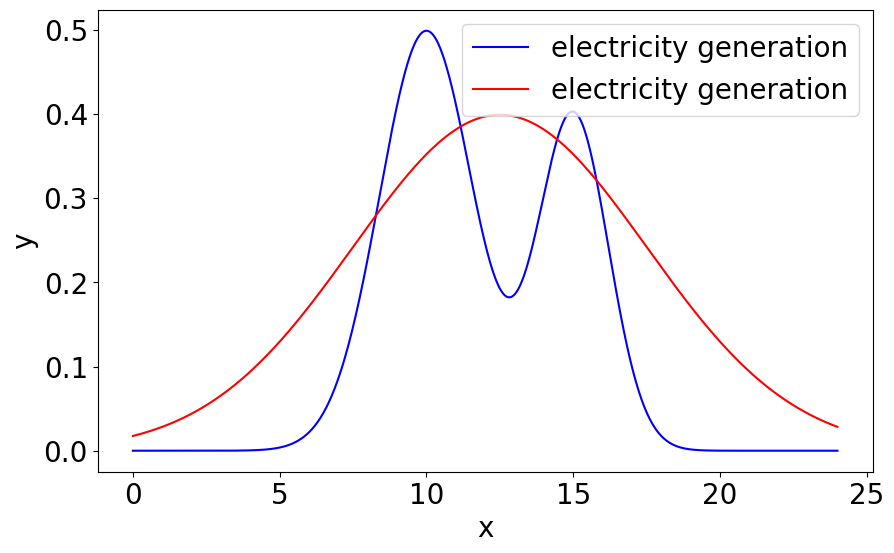

In [ ]:
from scipy.stats import norm
x = np.linspace(0, 24, 1000)
y1 = norm.pdf(x/2, loc=5, scale=0.8)+0.8*norm.pdf(x/1.5, loc=10, scale=0.8)
y2 = 1*norm.pdf(x/5, loc=2.5, scale=1)


plt.rcParams['font.size'] =20
plt.figure(figsize=(10, 6))
plt.plot(x, y1, 'b-', label='electricity generation')
plt.plot(x, y2, 'r-', label='electricity generation')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
#plt.title('Toy Example')
plt.show()

In [ ]:
x_train.shape

torch.Size([500, 5])

In [ ]:
train_data = TensorDataset(x_train, y_train)
data_loader = DataLoader(train_data, batch_size=32, shuffle=True)

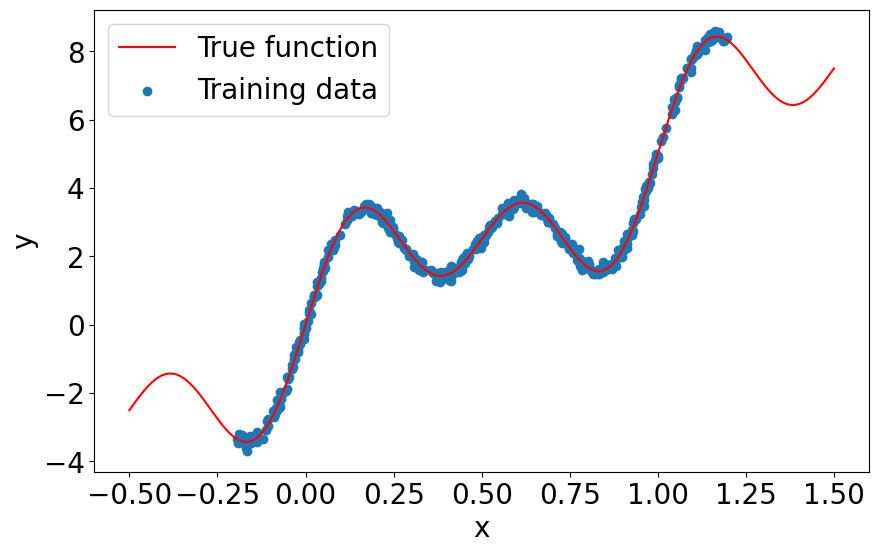

In [ ]:

plt.rcParams['font.size'] =20
plt.figure(figsize=(10, 6))
plt.plot(x_true, y_true, 'r-', label='True function')
plt.scatter(x_train[:, 0], y_train, label='Training data')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
#plt.title('Toy Example')
plt.show()

In [ ]:
x_val, y_val = dataset.__getitem__(200)
x_test, _ = dataset.__getitem__(500)

In [ ]:
x_test.shape

torch.Size([500, 5])

In [ ]:
def initialize_parameters(input_size, hidden_size, output_size):
    '''
    Initialize the parameters of the Bayesian Neural Network.
    The initial distribution is set to be Gaussian with mean 0 and standard deviation 1

    Parameters
    ----------
    input_size: int
        Number of input features.
    hidden_size: int
        Number of hidden units.
    output_size: int
        Number of output features.
    '''
    weight_1_mu = torch.zeros((hidden_size, input_size), requires_grad=True)
    weight_1_rho = torch.zeros((hidden_size, input_size), requires_grad=True)
    bias_1_mu = torch.zeros((hidden_size, 1), requires_grad=True)
    bias_1_rho = torch.zeros((hidden_size, 1), requires_grad=True)
    weight_2_mu = torch.zeros((output_size, hidden_size), requires_grad=True)
    weight_2_rho = torch.zeros((output_size, hidden_size), requires_grad=True)
    bias_2_mu = torch.zeros((output_size, 1), requires_grad=True)
    bias_2_rho = torch.zeros((output_size, 1), requires_grad=True)

    parameters = {
        "weight_1_mu": weight_1_mu, "weight_1_rho": weight_1_rho,
        "bias_1_mu": bias_1_mu, "bias_1_rho": bias_1_rho,
        "weight_2_mu": weight_2_mu, "weight_2_rho": weight_2_rho,
        "bias_2_mu": bias_2_mu, "bias_2_rho": bias_2_rho,
    }
    return parameters


In [ ]:
class BayesianNN(nn.Module):
    '''
    Bayesian Neural Network class.

    Attributes
    ----------
    parameters: dict
        Dictionary of parameters of weights and biases for the Bayesian Neural Network.

    Methods
    -------
    forward(x)
        Forward pass of the Bayesian Neural Network.
    '''
    def __init__(self, parameters):
        super(BayesianNN, self).__init__()
        self.parameters = parameters

    def forward(self, x):
        weight_1_sig = torch.nn.functional.softplus(self.parameters["weight_1_rho"])
        weight_1 = self.parameters["weight_1_mu"] + torch.mul(weight_1_sig, torch.randn_like(self.parameters["weight_1_mu"]))
        bias_1_sig = torch.nn.functional.softplus(self.parameters["bias_1_rho"])
        bias_1 = self.parameters["bias_1_mu"] + torch.mul(bias_1_sig, torch.randn_like(self.parameters["bias_1_mu"]))
        x = torch.matmul(weight_1, x.T) + bias_1
        x = torch.relu(x)

        weight_2_sig = torch.nn.functional.softplus(self.parameters["weight_2_rho"])
        weight_2 = self.parameters["weight_2_mu"] + torch.mul(weight_2_sig, torch.randn_like(self.parameters["weight_2_mu"]))
        bias_2_sig = torch.nn.functional.softplus(self.parameters["bias_2_rho"])
        bias_2 = self.parameters["bias_2_mu"] + torch.mul(bias_2_sig, torch.randn_like(self.parameters["bias_2_mu"]))
        y = torch.matmul(weight_2, x) + bias_2

        return y.T


In [ ]:
def ELBOloss(x_train, y_train, model, steps=200, alpha = 0.3, size = 50):
    '''
    ELBO loss function for Bayesian Neural Network regression.

    Parameters
    ----------
    x_train: torch.Tensor
        Input data for training.
    y_train: torch.Tensor
        Target data for training.
    model: BayesianNN
        Bayesian Neural Network model.
    steps: int, optional
        Number of steps for generating distribution of p(y|x,w). Default is 200.
    alpha: float, optional
        Regularization parameter for prior fitting term. Default is 0.3.
    size: int, optional
        Number of samples for the training set. Default is 50.

    Returns
    -------
    loss: torch.Tensor
        ELBO loss value.
    '''
    y_all = []
    for i in range(steps):
        y_all.append(model(x_train))


    # data fitting
    ## sampling the distribution of p(y|x,w) for the mean and std
    #batched_forward = vmap(model, randomness='different')
    #x_train_batched = x_train.expand(steps, -1, -1)
    #y_all = batched_forward(x_train_batched)
    y_all = torch.stack(y_all)
    y_mean = y_all.mean(dim=0)
    y_std = y_all.std(dim=0)
    ## computing data fitting term
    p_y = (((y_train - y_mean) ** 2) / y_std ** 2) + (2*torch.log(y_std))
    weighted_mse = torch.mean((((y_train - y_mean) ** 2) / y_std ** 2))*size
    log_sigma = torch.mean(2*torch.log(y_std))*size
    #MSEloss =  torch.nn.MSELoss(reduction='mean')
    data_fitting = torch.mean(p_y)*size #MSEloss(y_train, y_mean)*size#torch.mean(p_y)*size

    # prior matching
    ## computing prior matching term for each parameters for the distributions of weights and biases
    ## for normal distribution only
    prior_mu = 0
    prior_sigma = 1.0
    weight_1_sig = torch.nn.functional.softplus(model.parameters["weight_1_rho"])
    bias_1_sig = torch.nn.functional.softplus(model.parameters["bias_1_rho"])
    weight_2_sig = torch.nn.functional.softplus(model.parameters["weight_2_rho"])
    bias_2_sig = torch.nn.functional.softplus(model.parameters["bias_2_rho"])

    prior_matching = 0.5 * torch.sum((model.parameters["weight_1_mu"] ** 2 + (model.parameters["weight_1_mu"] - prior_mu) ** 2) / prior_sigma ** 2 - 0.5 - torch.log(weight_1_sig / prior_sigma))
    prior_matching += 0.5 * torch.sum((model.parameters["bias_1_mu"] ** 2 + (model.parameters["bias_1_mu"] - prior_mu) ** 2) / prior_sigma ** 2 - 0.5 - torch.log(bias_1_sig / prior_sigma))
    prior_matching += 0.5 * torch.sum((model.parameters["weight_2_mu"] ** 2 + (model.parameters["weight_2_mu"] - prior_mu) ** 2) / prior_sigma ** 2 - 0.5 - torch.log(weight_2_sig / prior_sigma))
    prior_matching += 0.5 * torch.sum((model.parameters["bias_2_mu"] ** 2 + (model.parameters["bias_2_mu"] - prior_mu) ** 2) / prior_sigma ** 2 - 0.5 - torch.log(bias_2_sig / prior_sigma))


    return data_fitting + alpha*prior_matching, data_fitting, weighted_mse, log_sigma, prior_matching


In [ ]:
class EarlyStopper:
    '''
    Early stopper class for training.

    Attributes
    ----------
    patience: int
        Number of epochs to wait before early stopping.
    min_delta: float
        Minimum change in validation loss to qualify as an improvement.

    Methods
    -------
    early_stop(validation_loss)
        Check if early stopping should be triggered.
    '''
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False



In [ ]:

x_test = torch.linspace(-0.5, 1.5, 1000).unsqueeze(1)
x_test_power = np.column_stack([x_test**i for i in range(1, power+1)])


In [ ]:
x_test_power.shape

(1000, 5)

Epoch [10/42], train loss: 1155.1599, validation loss: 631.5031
Epoch [20/42], train loss: 1414.3719, validation loss: 622.9854
Epoch [30/42], train loss: 1001.6443, validation loss: 531.5351
Epoch [40/42], train loss: 717.1922, validation loss: 463.6598


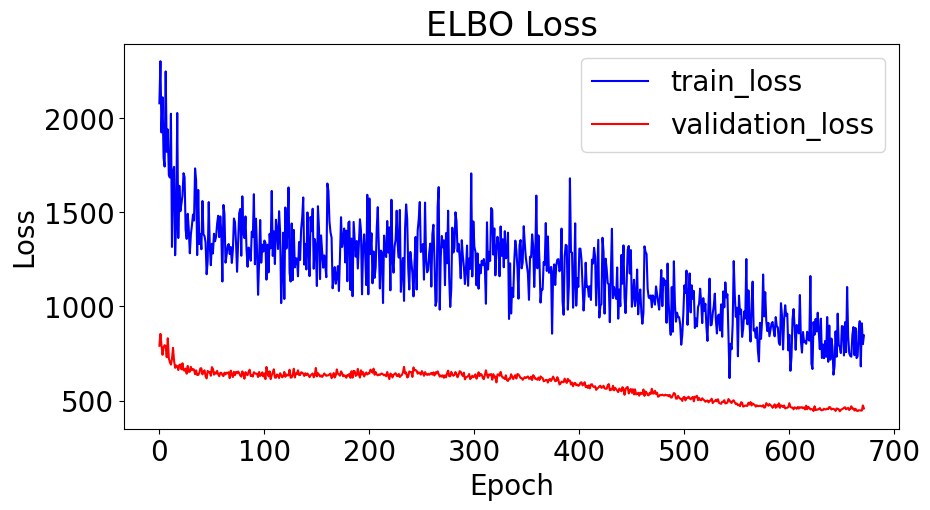

In [ ]:
params = initialize_parameters(power, 10, 1)
model = BayesianNN(params)
optimizer = optim.Adam([param for param in params.values()], lr=0.005)


early_stopper = EarlyStopper(patience=10, min_delta=10)
num_epochs = 42

x_test = torch.linspace(-0.5, 1.5, 1000).unsqueeze(1)
x_test = np.column_stack([x_test**i for i in range(1, power+1)])
x_test = torch.from_numpy(x_test).float()


train_losses = []
train_weighted_mses = []
train_log_sigmas = []
train_data_fittings = []
train_prior_matchings= []

val_losses = []
val_weighted_mses = []
val_log_sigmas = []
val_data_fittings = []
val_prior_matchings= []
alpha = 1


for epoch in range(num_epochs):
    model.train()
    #optimizer.zero_grad()
    #loss, t_data_fitting, t_weighted_mse, t_log_sigma, t_prior_matching = ELBOloss(x_train, y_train, model, alpha=alpha, size = x_train.shape[0])
    #loss.backward()
    #optimizer.step()
    epoch_losses = []
    epoch_data_fitting = []
    epoch_weighted_mse = []
    epoch_log_sigma = []
    epoch_prior_matching = []

    for x_batch, y_batch in data_loader:
        optimizer.zero_grad()
        loss, t_data_fitting, t_weighted_mse, t_log_sigma, t_prior_matching = ELBOloss(x_batch, y_batch, model, alpha=alpha, size = x_train.shape[0])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        train_weighted_mses.append(t_weighted_mse.item())
        train_log_sigmas.append(t_log_sigma.item())
        train_data_fittings.append(t_data_fitting.item())
        train_prior_matchings.append(t_prior_matching.item())

        val_loss, v_data_fitting, v_weighted_mse, v_log_sigma, v_prior_matching = ELBOloss(x_val, y_val, model, alpha=alpha, size = x_val.shape[0])
        val_losses.append(val_loss.item())
        val_weighted_mses.append(v_weighted_mse.item())
        val_log_sigmas.append(v_log_sigma.item())
        val_data_fittings.append(v_data_fitting.item())
        val_prior_matchings.append(v_prior_matching.item())
    #print(f'Epoch {epoch}, Train Loss {loss.item()}, Validation Loss {val_loss.item()}\n')



    if epoch >100 and early_stopper.early_stop(val_loss):
        print(f"Early stop, Epoch {epoch}, train loss: {loss:.4f}, validation loss: {val_loss:.4f}")
        #break

    # save the base prediction at the first epoch
    if epoch == 1:
        y_preds = []
        for _ in range(100):
            y_pred = model(x_test).detach().numpy()
            y_preds.append(y_pred)

        y_preds = np.array(y_preds)
        base_y_mean = y_preds.mean(axis=0)

    # save the prediction after first quater of epochs
    if epoch == torch.ceil(torch.tensor(num_epochs/4)):
        y_preds = []
        for _ in range(100):
            y_pred = model(x_test).detach().numpy()
            y_preds.append(y_pred)

        y_preds = np.array(y_preds)
        first_y_mean = y_preds.mean(axis=0)
        second_y_mean = y_preds.mean(axis=0)
        third_y_mean = y_preds.mean(axis=0)

    # save the prediction after second quater of epochs
    if epoch == torch.ceil(torch.tensor(num_epochs/2)):
        y_preds = []
        for _ in range(100):
            y_pred = model(x_test).detach().numpy()
            y_preds.append(y_pred)

        y_preds = np.array(y_preds)
        second_y_mean = y_preds.mean(axis=0)
        third_y_mean = y_preds.mean(axis=0)

    # save the prediction after third quater of epochs
    if epoch == torch.ceil(torch.tensor(num_epochs*3/4)):
        y_preds = []
        for _ in range(100):
            y_pred = model(x_test).detach().numpy()
            y_preds.append(y_pred)

        y_preds = np.array(y_preds)
        third_y_mean = y_preds.mean(axis=0)

    # print loss for every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], train loss: {loss:.4f}, validation loss: {val_loss:.4f}')

# plot loss function or training and validatin sets
plt.figure(figsize=(10, 5))
plt.plot(train_losses, color = "blue", label='train_loss')
plt.plot(val_losses, color = "red", label='validation_loss')
plt.title("ELBO Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()



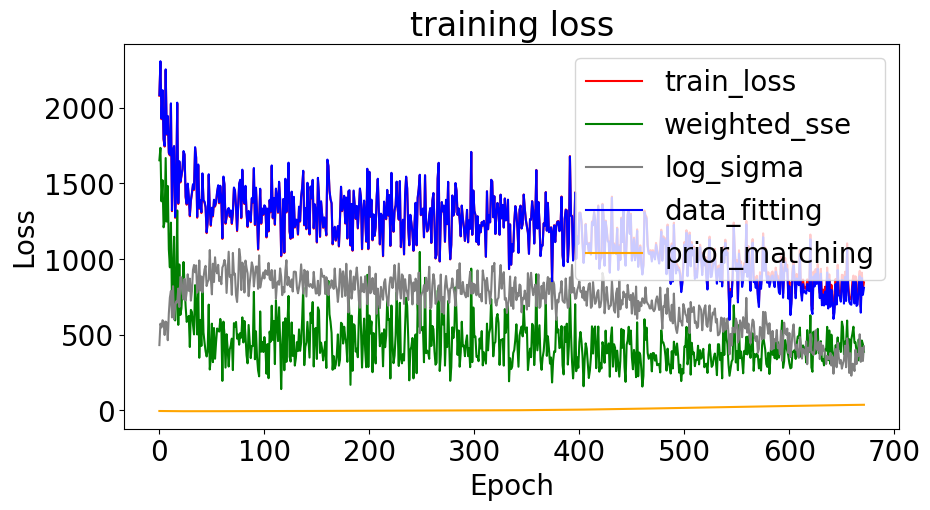

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, color = "red", label='train_loss')
plt.plot(train_weighted_mses, color = "green", label='weighted_sse')
plt.plot(train_log_sigmas, color = "grey", label='log_sigma')
plt.plot(train_data_fittings, color = "blue", label='data_fitting')
plt.plot(train_prior_matchings, color = "orange", label='prior_matching')
plt.title("training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


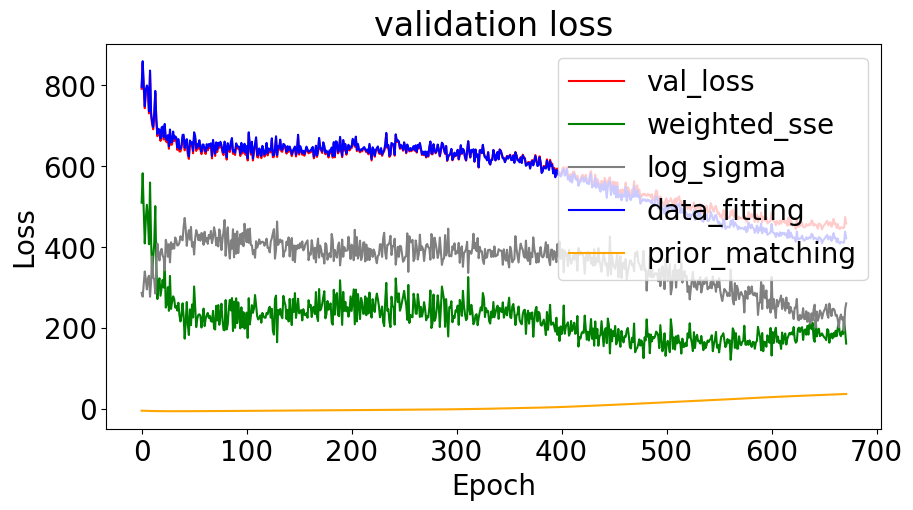

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(val_losses, color = "red", label='val_loss')
plt.plot(val_weighted_mses, color = "green", label='weighted_sse')
plt.plot(val_log_sigmas, color = "grey", label='log_sigma')
plt.plot(val_data_fittings, color = "blue", label='data_fitting')
plt.plot(val_prior_matchings, color = "orange", label='prior_matching')
plt.title("validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

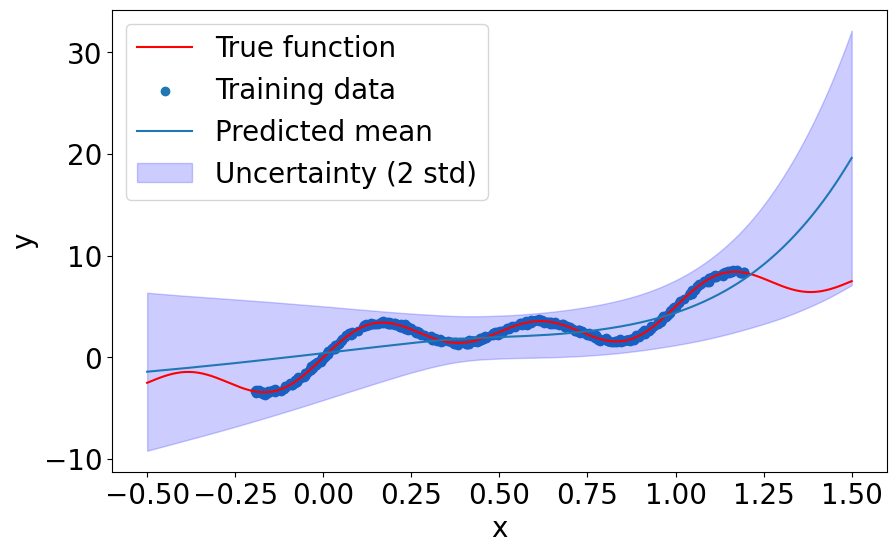

In [ ]:
# predict y with the trained model
model.eval()
y_preds = []

# estimat the std of predicted y
for _ in range(100):
    y_pred = model(x_test).detach().numpy()
    y_preds.append(y_pred)

y_preds = np.array(y_preds)
y_mean = y_preds.mean(axis=0)
y_std = y_preds.std(axis=0)



# plot
plt.rcParams['font.size'] =20
plt.figure(figsize=(10, 6))
plt.plot(x_true, y_true, 'r-', label='True function')
plt.scatter(x_train[:, 0], y_train, label='Training data')

#plt.plot(x_test.numpy(), base_y_mean, color="0.9", label='base prediction')
#plt.plot(x_test.numpy(), first_y_mean, color="0.7", label='1st quarter prediction')
#plt.plot(x_test.numpy(), second_y_mean, color="0.5", label='2nd quarter prediction')
#plt.plot(x_test.numpy(), third_y_mean, color="0.3", label='3rd quarter prediction')

plt.plot(x_test[:, 0].numpy(), y_mean, label='Predicted mean')
plt.fill_between(x_test[:, 0].numpy().squeeze(), y_mean.squeeze() - 1.96 * y_std.squeeze(), y_mean.squeeze() + 1.96 * y_std.squeeze(), color='blue', alpha=0.2, label='Uncertainty (2 std)')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
#plt.title('Bayesian Neural Network Regression with Variational Inference')
plt.show()